In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy import stats

In [ ]:
df = pd.read_csv('/content/energydata.csv', index_col='Date', parse_dates=True)

In [ ]:
df.head()

,Energy Consumption
Date,
2020-01-01,305.311409
2020-01-02,299.374329
2020-01-03,307.646359
2020-01-04,316.811967
2020-01-05,299.651923


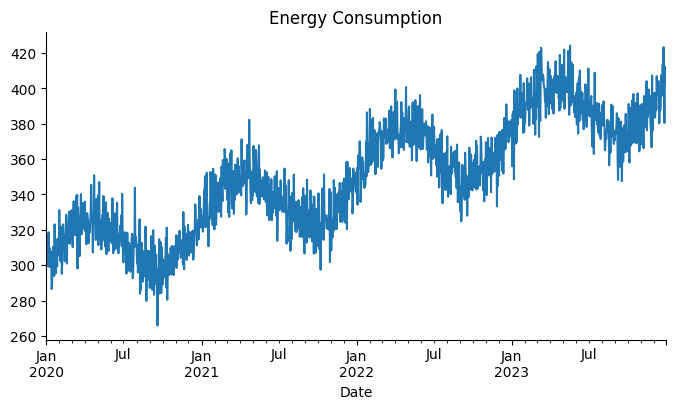

In [ ]:
from matplotlib import pyplot as plt
df['Energy Consumption'].plot(kind='line', figsize=(8, 4), title='Energy Consumption')
plt.gca().spines[['top', 'right']].set_visible(False)

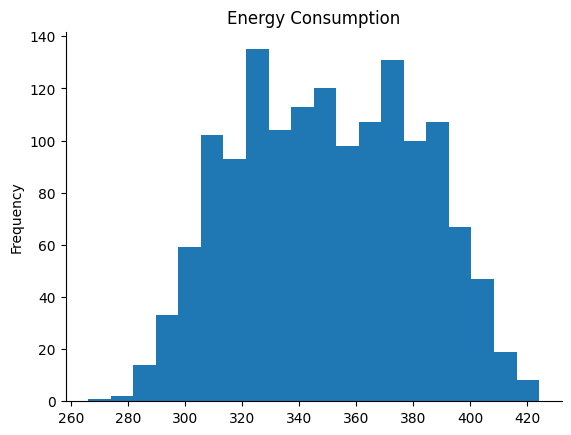

In [ ]:
# Energy Consumption
from matplotlib import pyplot as plt
df['Energy Consumption'].plot(kind='hist', bins=20, title='Energy Consumption')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

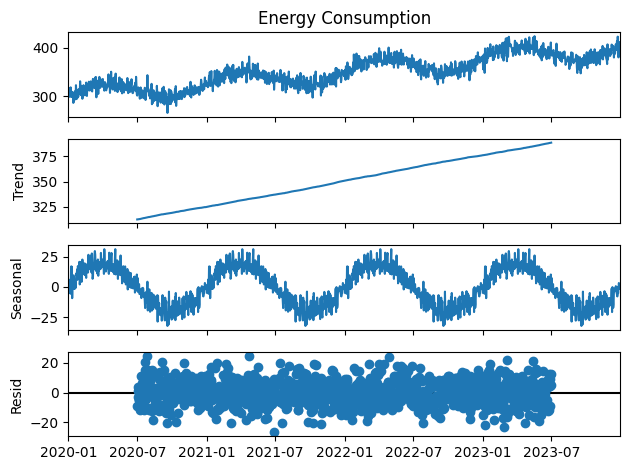

In [ ]:
result = seasonal_decompose(df['Energy Consumption'], model='additive', period=365)
fig = result.plot()
plt.show()

In [ ]:
df.describe()


,Energy Consumption
count,1460.000000
mean,350.451726
std,31.566215
min,265.886301
25%,324.913290
50%,349.962555
75%,375.550666
max,424.172656


In [ ]:
# scaler = MinMaxScaler()
# df_scaled = scaler.fit_transform(df)
# df_scaled = pd.DataFrame(df_scaled, columns=df.columns, index=df.index)
# df_scaled.head()

In [ ]:
# print how many years in the dataset
print('Number of years in the dataset:', len(df.index.year.unique()))

Number of years in the dataset: 4


In [ ]:
# # split data into testing and training, 3 years to train, 1 year to test
# train_size = len(df) - 364
# train_data = df_scaled[:train_size]
# test_data = df_scaled[train_size:]
# train_data = train_data[['Energy Consumption']]

# # display tail of train_data and head of test_data
# print('Train data tail:\n', train_data.tail())
# print('Test data head:\n', test_data.head())

In [ ]:
def detect_and_replace_outliers(df, column='Energy Consumption', window=30, threshold=0.8):
    """
    Detect and replace outliers using seasonal patterns

    Parameters:
    df: DataFrame with datetime index
    column: column name to check for outliers
    window: rolling window size for seasonal pattern
    threshold: IQR threshold for outlier detection
    """
    df_processed = df.copy()
    df_processed['outlier'] = False

    # Create a rolling median for comparison
    df_processed['rolling_median'] = df_processed[column].rolling(
        window=window, center=True, min_periods=1
    ).median()

    # Create rolling IQR bounds
    rolling_Q1 = df_processed[column].rolling(window=window, center=True, min_periods=1).quantile(0.25)
    rolling_Q3 = df_processed[column].rolling(window=window, center=True, min_periods=1).quantile(0.75)
    rolling_IQR = rolling_Q3 - rolling_Q1

    lower_bound = rolling_Q1 - threshold * rolling_IQR
    upper_bound = rolling_Q3 + threshold * rolling_IQR

    # Identify outliers
    outliers_mask = (df_processed[column] < lower_bound) | (df_processed[column] > upper_bound)
    df_processed.loc[outliers_mask, 'outlier'] = True

    # Store original values before replacement
    original_values = df_processed.loc[outliers_mask, column].copy()

    # Replace outliers with interpolated values
    for idx in df_processed[outliers_mask].index:
        # Get the season-specific window
        season_start = idx - pd.Timedelta(days=window//2)
        season_end = idx + pd.Timedelta(days=window//2)

        # Get non-outlier values in the seasonal window
        seasonal_values = df_processed[
            (df_processed.index >= season_start) &
            (df_processed.index <= season_end) &
            (~df_processed['outlier'])
        ][column]

        if len(seasonal_values) > 0:
            # Replace with median of seasonal non-outlier values
            df_processed.loc[idx, column] = seasonal_values.median()
        else:
            # If no good seasonal values, use rolling median
            df_processed.loc[idx, column] = df_processed.loc[idx, 'rolling_median']

    # Plotting
    plt.figure(figsize=(15, 10))

    # Plot original data
    plt.subplot(2, 1, 1)
    plt.plot(df_processed.index, df_processed[column], label='Data with Outliers', alpha=0.7)
    plt.scatter(original_values.index, original_values,
               color='red', label='Detected Outliers', alpha=0.5)
    plt.title('Original Data with Detected Outliers')
    plt.legend()
    plt.grid(True)

    # Plot processed data
    plt.subplot(2, 1, 2)
    plt.plot(df_processed.index, df_processed[column],
             label='Data with Replaced Outliers', color='green')
    plt.title('Data with Replaced Outliers')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    # Print statistics
    num_outliers = outliers_mask.sum()
    print(f"\nOutlier Statistics:")
    print(f"Total data points: {len(df)}")
    print(f"Outliers detected and replaced: {num_outliers} ({num_outliers/len(df)*100:.2f}%)")

    # Drop the helper columns
    df_processed.drop(['rolling_median', 'outlier'], axis=1, inplace=True)

    return df_processed

In [ ]:
# Create weekly plots with outliers highlighted
def plot_weekly_outliers(df, df_with_outliers, bounds_dict, week_length=7):
    num_chunks = len(df) // week_length + (1 if len(df) % week_length != 0 else 0)
    num_cols = 2
    num_rows = (num_chunks + 1) // 2

    plt.figure(figsize=(15, 5 * num_rows))

    for i in range(num_chunks):
        plt.subplot(num_rows, num_cols, i + 1)

        start_idx = i * week_length
        end_idx = min((i + 1) * week_length, len(df))

        chunk = df.iloc[start_idx:end_idx]
        chunk_outliers = df_with_outliers[
            (df_with_outliers.index >= chunk.index[0]) &
            (df_with_outliers.index <= chunk.index[-1]) &
            df_with_outliers['outlier']
        ]

        # Plot regular data points
        plt.plot(chunk.index, chunk['Energy Consumption'],
                label='Regular Data', color='blue')

        # Plot outliers
        if not chunk_outliers.empty:
            plt.scatter(chunk_outliers.index,
                       chunk_outliers['Energy Consumption'],
                       color='red', label='Outliers')

        # Plot bounds
        lower_bound, upper_bound = bounds_dict[i]
        plt.axhline(y=lower_bound, color='g', linestyle='--',
                   label='Lower Bound')
        plt.axhline(y=upper_bound, color='g', linestyle='--',
                   label='Upper Bound')

        plt.title(f'week {i+1}')
        plt.xticks(rotation=45)
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.show()

In [ ]:
# Apply the weekly outlier detection
# First ensure the index is datetime
if not isinstance(df.index, pd.DatetimeIndex):
    df.index = pd.date_range(start='2020-01-01', periods=len(df), freq='D')

# Detect outliers with different season lengths and thresholds
week_length = 7
threshold = 1

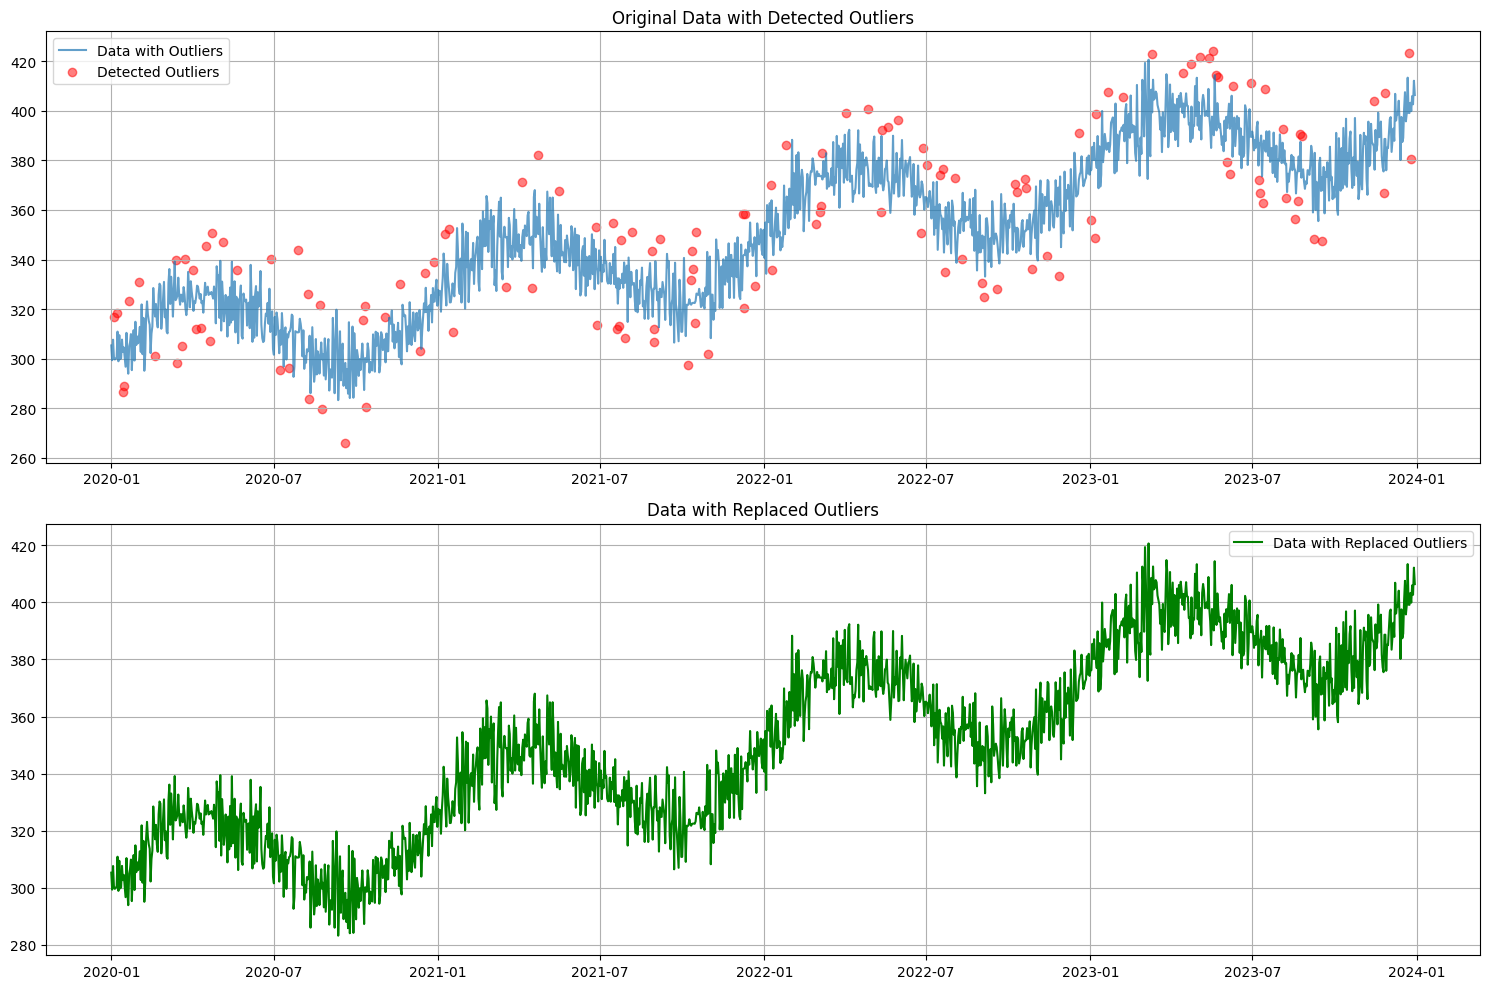


Outlier Statistics:
Total data points: 1460
Outliers detected and replaced: 133 (9.11%)


In [ ]:
results = {}
processed_df = detect_and_replace_outliers(
            df, window=30, threshold=0.8
        )
results[(30, 0.8)] = processed_df



In [ ]:
final_processed_df = results[(30, 0.8)]

In [ ]:
# Prepare the processed data for modeling
def prepare_processed_data(processed_data):
    """
    Prepare the processed data for modeling
    """
    # Scale the data
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler()
    scaled_data = pd.DataFrame(
        scaler.fit_transform(processed_data[['Energy Consumption']]),
        columns=['Energy Consumption'],
        index=processed_data.index
    )

    # Split into train and test
    train_size = len(scaled_data) - 364
    train_data = scaled_data[:train_size]
    test_data = scaled_data[train_size:]

    return train_data, test_data, scaler

# Prepare the data
train_data, test_data, scaler = prepare_processed_data(final_processed_df)

print("\nFinal Dataset Shapes:")
print(f"Training data: {train_data.shape}")
print(f"Test data: {test_data.shape}")


Final Dataset Shapes:
Training data: (1096, 1)
Test data: (364, 1)


In [ ]:
# Convert train_data to a NumPy array
train_data_np = train_data.values
test_data_np = test_data.values


In [ ]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [ ]:
# Define the generator for one-step prediction
# n_steps=30


In [ ]:
# Define the number of steps to predict
# n_steps = 7

# # Adjust the multi-step targets to match the length of train_data
# multi_step_targets = np.array([train_data_np[i:i+n_steps] for i in range(len(train_data_np) - n_steps)])
# multi_step_data = train_data_np[:len(multi_step_targets)]

# # create the generator with the adjusted data and targets
# multi_step_generator = TimeseriesGenerator(multi_step_data, multi_step_targets, length=30, batch_size=3)

In [ ]:
# one_time_X, one_time_y = one_step_generator[0]
# # print length of X and Y
# print(f'Length of X: {len(one_time_X)}')
# print(f'Length of y: {len(one_time_y)}')

In [ ]:
# # Access the first sample within the batch
# single_X, single_y = one_time_X[0], one_time_y[0]
# print(f'Single X:\n {single_X.flatten()}')
# print(f'Single y:\n {single_y}')

In [ ]:
# multi_time_X, multi_time_y = multi_step_generator[0]
# # print length of X and Y
# print(f'Length of X: {len(multi_time_X)} , X shape {multi_time_X.shape}')
# print(f'Length of y: {len(multi_time_y)}')

In [ ]:
# # Access the first sample within the batch
# multi_single_X, multi_single_y = multi_time_X[0], multi_time_y[0]
# print(f'we give this Single X:\n {multi_single_X.flatten()}')
# print(f'we predict this Single y:\n {multi_single_y}')

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

In [ ]:
# Define configurations
neurons_options = [50, 100, 200]  # Number of neurons
timesteps_options = [7, 14, 30]   # Number of timesteps
layers_options = [1, 2, 3]          # Number of layers
optimizers_options = ['adam', 'sgd', 'rmsprop']  # Different optimizers

# Placeholder for metrics
metrics_history = {}

In [ ]:
def create_and_fit_model(neurons, timesteps, layers, optimizer, epochs=50):
    one_step_generator = TimeseriesGenerator(train_data_np, train_data_np, length=timesteps, batch_size=3)
    model = Sequential()

    for i in range(layers):
        if i == 0:
            model.add(LSTM(neurons, activation='relu', return_sequences=(layers > 1), input_shape=(timesteps, 1)))
        else:
            model.add(LSTM(neurons, activation='relu', return_sequences=(i < layers - 1)))

    model.add(Dense(1))  # Output layer
    model.compile(optimizer=optimizer, loss='mse')

    # Fit the model
    history = model.fit(one_step_generator, epochs=epochs, verbose=0)

    return model, history

In [ ]:
def evaluate_and_visualize_model(model, train_data_np, test_data_np, n_steps, test_data):
    # Make a single prediction
    last_sequence = train_data_np[-n_steps:]
    X_pred = last_sequence.reshape((1, n_steps, 1))
    prediction = model.predict(X_pred, verbose=0)[0][0]

    # Get the actual first day from test data for comparison
    actual_first_day = test_data_np[0]

    # Visualize the prediction
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(train_data_np[-n_steps:].flatten())), train_data_np[-n_steps:].flatten(),
             label='Last 30 days of training', marker='o')
    plt.plot(n_steps, prediction, 'r*', markersize=15, label='Prediction')
    plt.plot(n_steps, actual_first_day, 'g*', markersize=15, label='Actual')
    plt.xlabel('Time steps')
    plt.ylabel('Scaled Energy Consumption')
    plt.title('Prediction vs Actual Value')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Prepare for multiple predictions
    predictions = []
    current_sequence = train_data_np[-n_steps:].copy()

    # Predict each day in the test period
    for i in range(len(test_data_np)):
        X = current_sequence.reshape((1, n_steps, 1))
        next_pred = model.predict(X, verbose=0)[0][0]
        predictions.append(next_pred)

        # Update sequence
        current_sequence = np.roll(current_sequence, -1)
        current_sequence[-1] = test_data_np[i]

    # Calculate error metrics
    mse = mean_squared_error(test_data_np, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(test_data_np, predictions)
    r2 = r2_score(test_data_np, predictions)

    # Plotting actual vs predicted values
    test_dates = test_data.index if hasattr(test_data, 'index') else np.arange(len(test_data_np))
    plt.figure(figsize=(15, 8))
    train_dates = train_data.index[-n_steps:] if hasattr(train_data, 'index') else np.arange(-n_steps, 0)

    # Plot last n days of training data
    plt.plot(train_dates, train_data_np[-n_steps:],
             label='Last 30 Days of Training',
             color='gray',
             alpha=0.5)

    # Plot test data and predictions
    plt.plot(test_dates, test_data_np,
             label='Actual Values',
             linewidth=2)
    plt.plot(test_dates, predictions,
             label='Predictions',
             linewidth=2,
             linestyle='--')

    plt.title('Energy Consumption: Actual vs Predicted Values', pad=20)
    plt.xlabel('Date')
    plt.ylabel('Scaled Energy Consumption')
    plt.legend()
    plt.grid(True)

    # Add error metrics as text box
    metrics_text = f'Error Metrics:\nRMSE: {rmse:.4f}\nMAE: {mae:.4f}\nR²: {r2:.4f}'
    plt.figtext(0.02, 0.02, metrics_text, fontsize=10, bbox=dict(facecolor='white', alpha=0.8))

    # Rotate x-axis labels if using dates
    if hasattr(test_data, 'index'):
        plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

    # Print detailed metrics
    print("\nDetailed Performance Metrics:")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"R-squared (R²): {r2:.4f}")

    # Calculate and display some additional analysis
    print("\nPrediction Analysis:")
    print(f"Mean Actual Value: {np.mean(test_data_np):.4f}")
    print(f"Mean Predicted Value: {np.mean(predictions):.4f}")
    print(f"Std Actual Value: {np.std(test_data_np):.4f}")
    print(f"Std Predicted Value: {np.std(predictions):.4f}")



=== Group 1: Testing Different Neurons ===

Training model with neurons=50, timesteps=7, layers=1, optimizer=adam


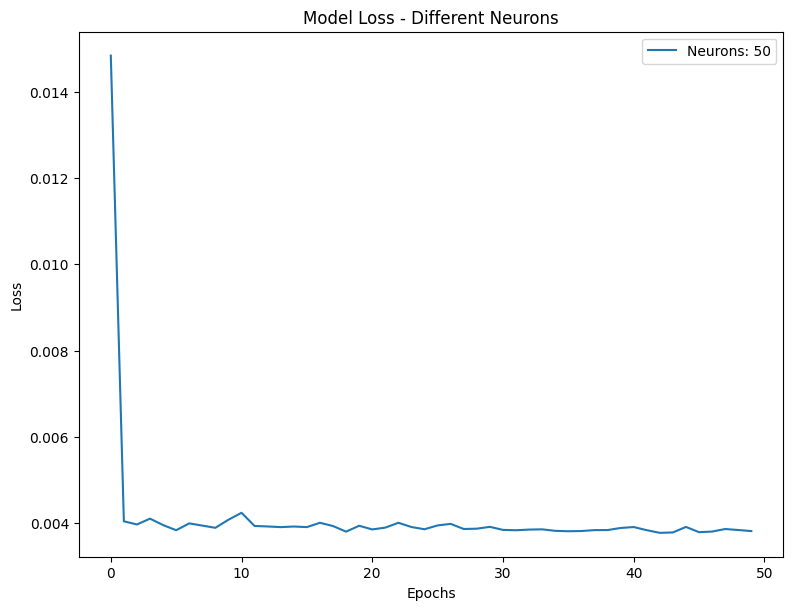

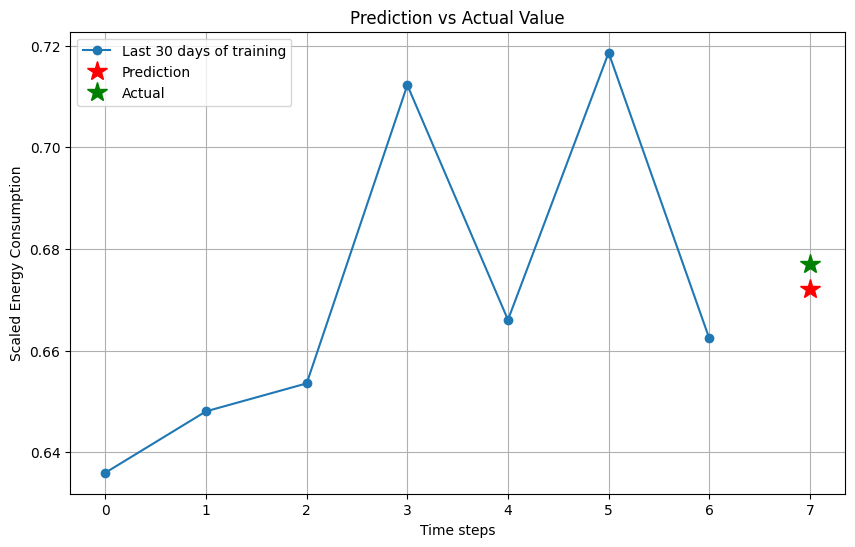

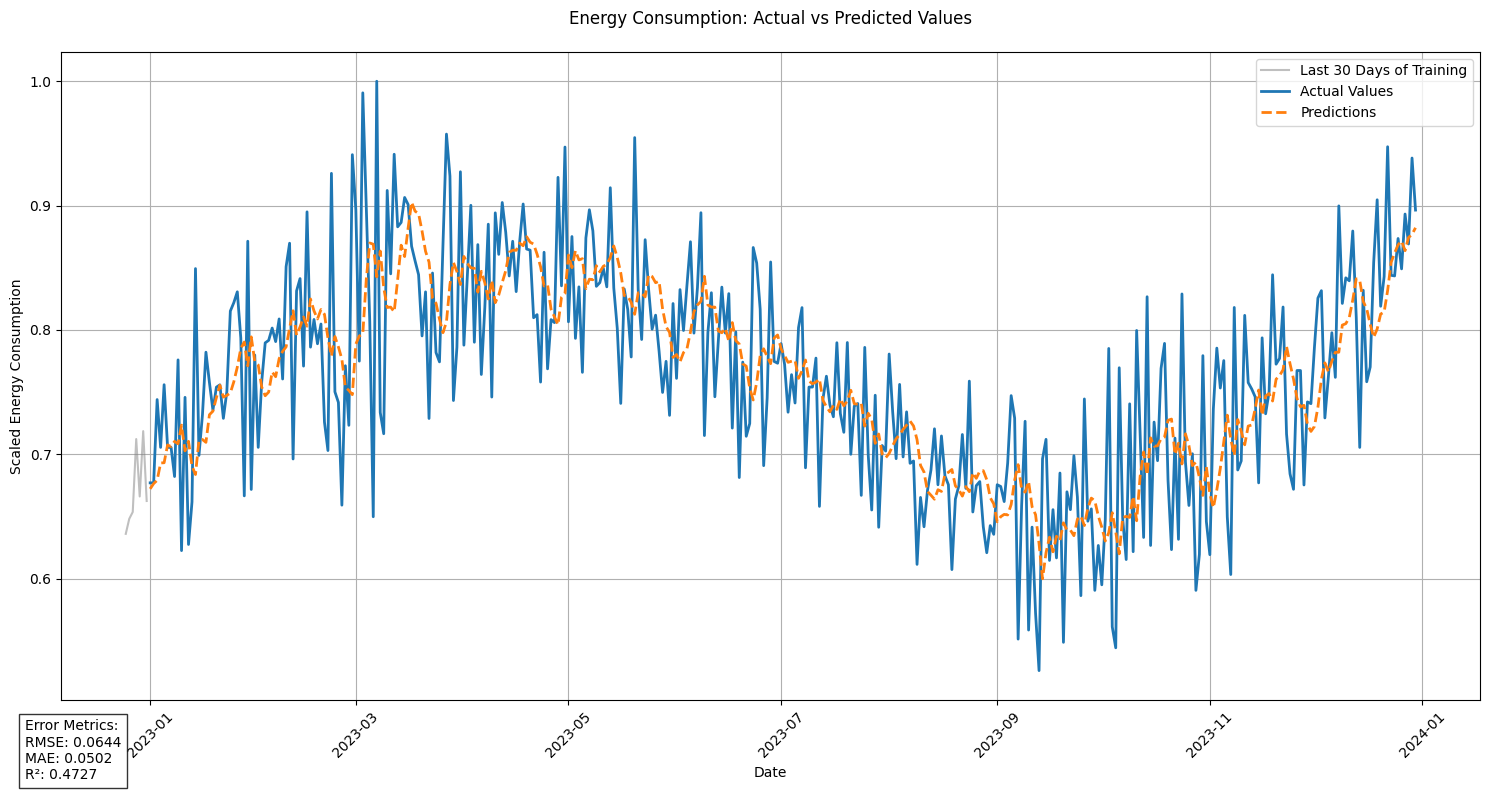


Detailed Performance Metrics:
Root Mean Squared Error (RMSE): 0.0644
Mean Absolute Error (MAE): 0.0502
R-squared (R²): 0.4727

Prediction Analysis:
Mean Actual Value: 0.7632
Mean Predicted Value: 0.7612
Std Actual Value: 0.0887
Std Predicted Value: 0.0708

Training model with neurons=100, timesteps=7, layers=1, optimizer=adam


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


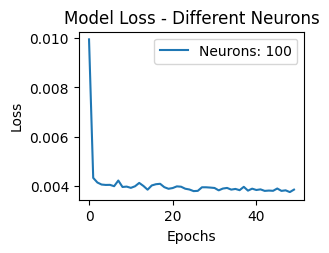

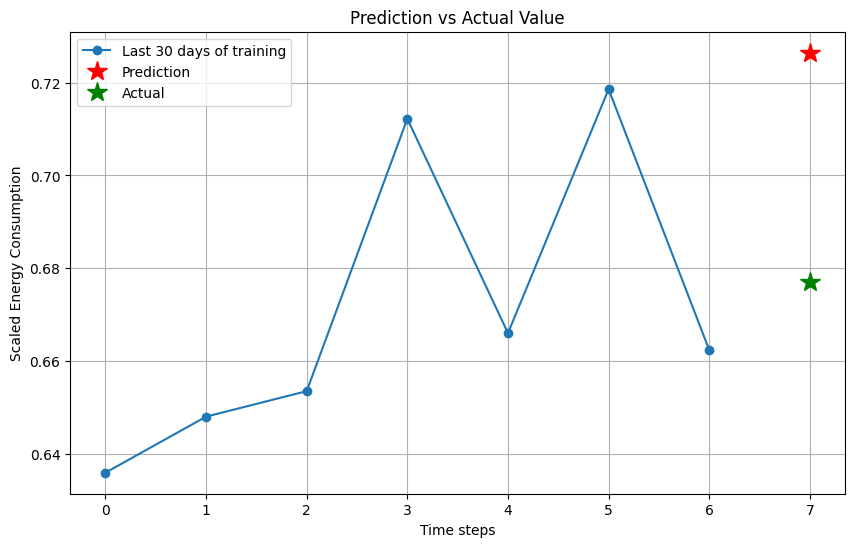

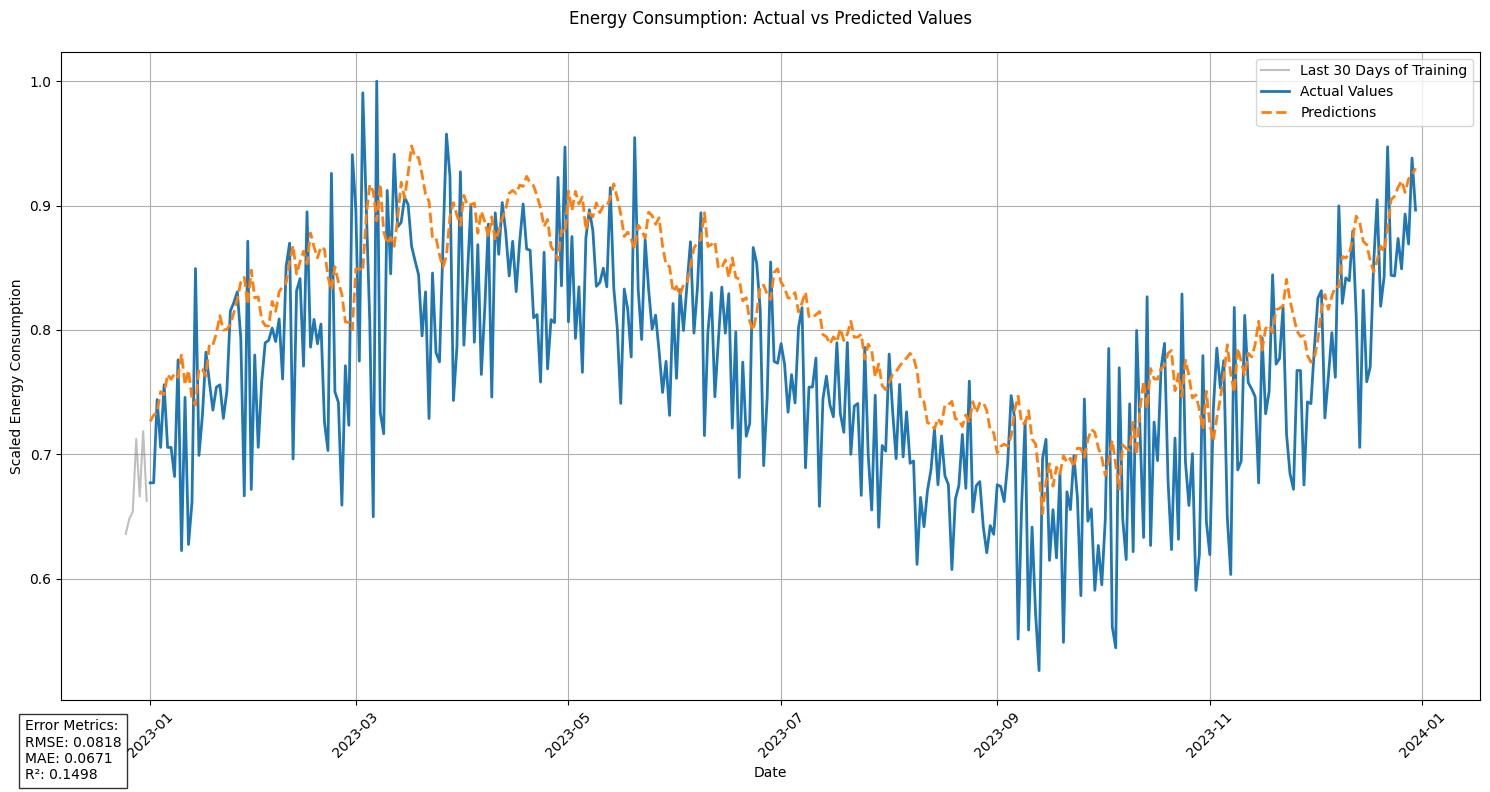


Detailed Performance Metrics:
Root Mean Squared Error (RMSE): 0.0818
Mean Absolute Error (MAE): 0.0671
R-squared (R²): 0.1498

Prediction Analysis:
Mean Actual Value: 0.7632
Mean Predicted Value: 0.8140
Std Actual Value: 0.0887
Std Predicted Value: 0.0683

Training model with neurons=200, timesteps=7, layers=1, optimizer=adam


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


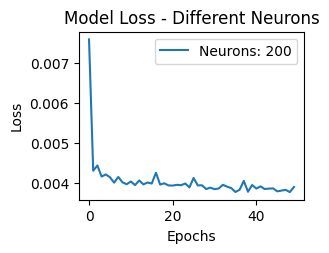

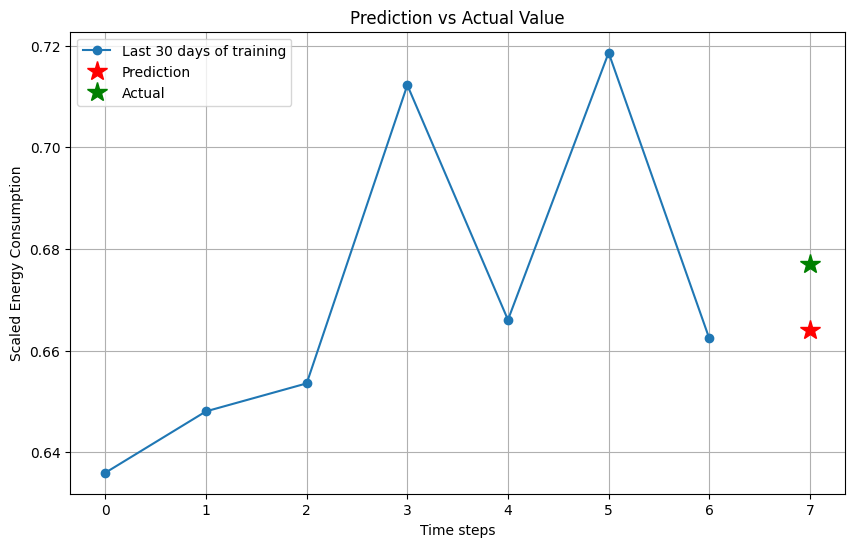

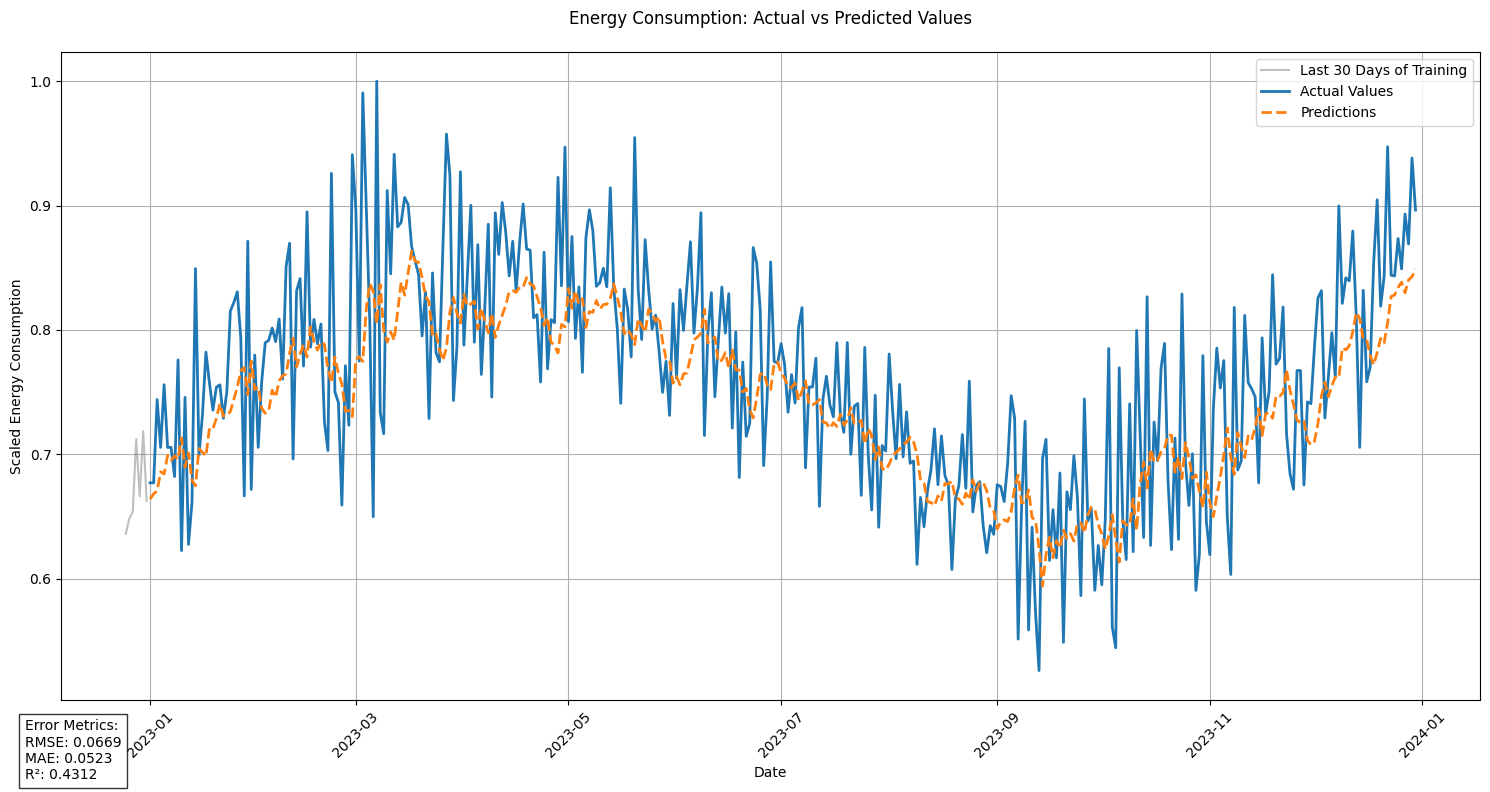


Detailed Performance Metrics:
Root Mean Squared Error (RMSE): 0.0669
Mean Absolute Error (MAE): 0.0523
R-squared (R²): 0.4312

Prediction Analysis:
Mean Actual Value: 0.7632
Mean Predicted Value: 0.7431
Std Actual Value: 0.0887
Std Predicted Value: 0.0619


In [ ]:
# Define configurations
neurons_options = [50, 100, 200]         # Number of neurons
timesteps_options = [7, 14, 30]          # Number of timesteps
layers_options = [1, 2, 3]               # Number of layers
optimizers_options = ['adam', 'sgd', 'rmsprop']  # Optimizers

# Store metrics
metrics_history = {}

# Create figure for plotting
plt.figure(figsize=(20, 15))

# Group 1: Test different neurons (first 3 models)
print("\n=== Group 1: Testing Different Neurons ===")
for neurons in neurons_options:
    key = f"neurons_test_n{neurons}"
    print(f"\nTraining model with neurons={neurons}, timesteps=7, layers=1, optimizer=adam")

    model, history = create_and_fit_model(
        neurons=neurons,
        timesteps=7,  # fixed
        layers=1,     # fixed
        optimizer='adam'  # fixed
    )

    metrics_history[key] = {
        'model': model,
        'history': history,
        'config': {'neurons': neurons, 'timesteps': 7, 'layers': 1, 'optimizer': 'adam'}
    }

    # Plot loss for neurons comparison
    plt.subplot(2, 2, 1)
    plt.plot(history.history['loss'], label=f'Neurons: {neurons}')
    plt.title('Model Loss - Different Neurons')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Evaluate and visualize model predictions
    evaluate_and_visualize_model(model, train_data_np, test_data_np, 7, test_data)



=== Group 2: Testing Different Timesteps ===

Training model with neurons=100, timesteps=7, layers=1, optimizer=adam


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


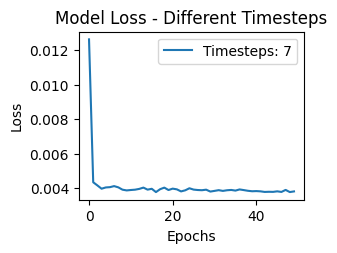

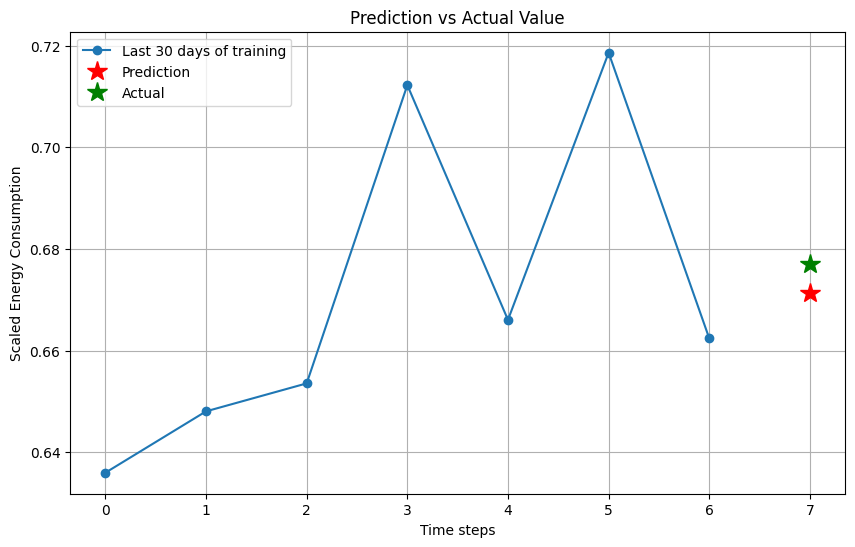

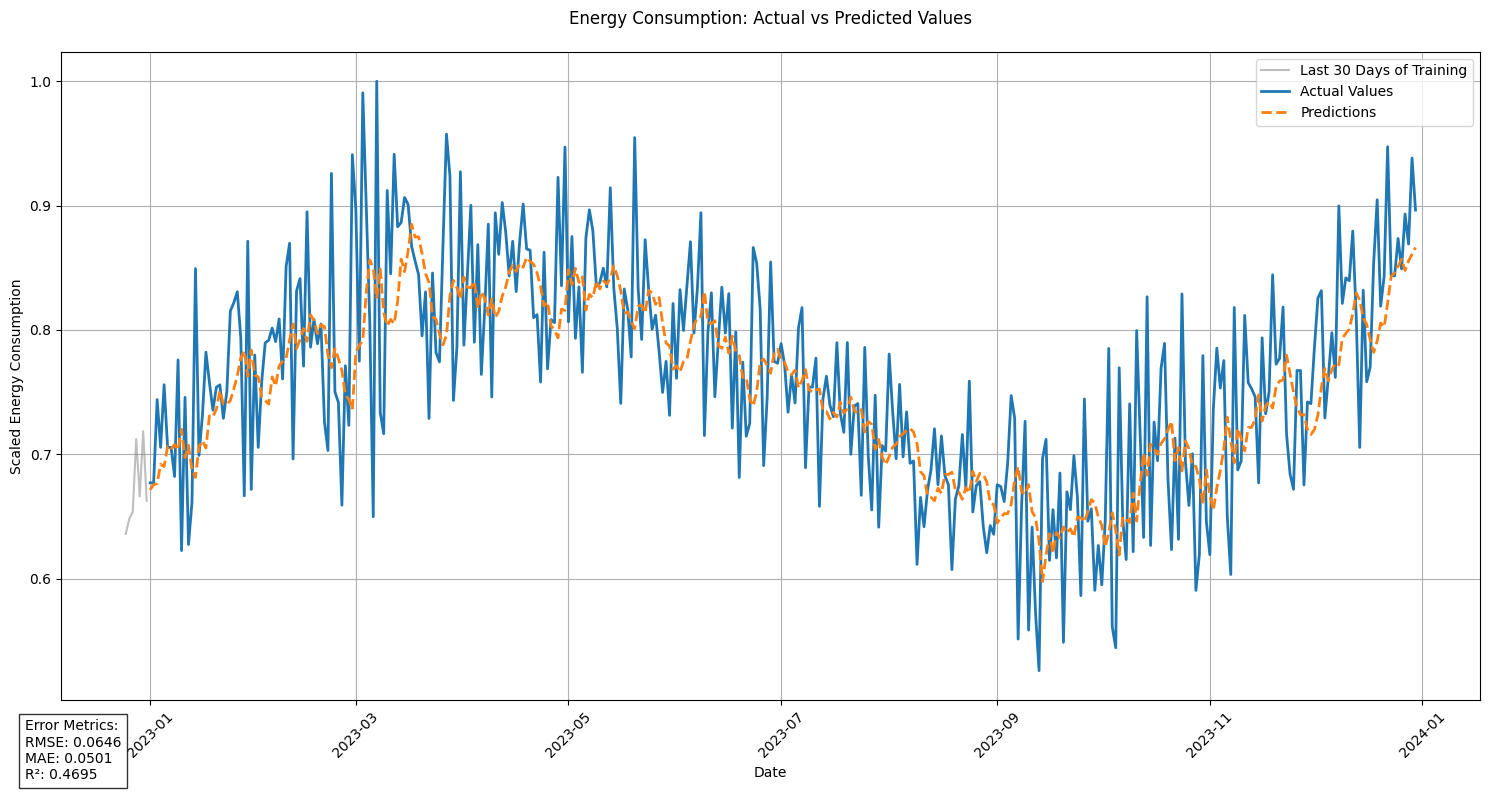


Detailed Performance Metrics:
Root Mean Squared Error (RMSE): 0.0646
Mean Absolute Error (MAE): 0.0501
R-squared (R²): 0.4695

Prediction Analysis:
Mean Actual Value: 0.7632
Mean Predicted Value: 0.7534
Std Actual Value: 0.0887
Std Predicted Value: 0.0659

Training model with neurons=100, timesteps=14, layers=1, optimizer=adam


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


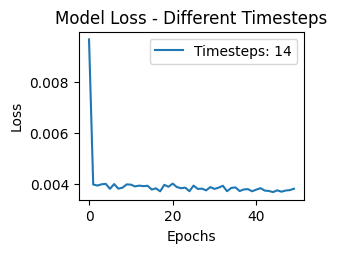

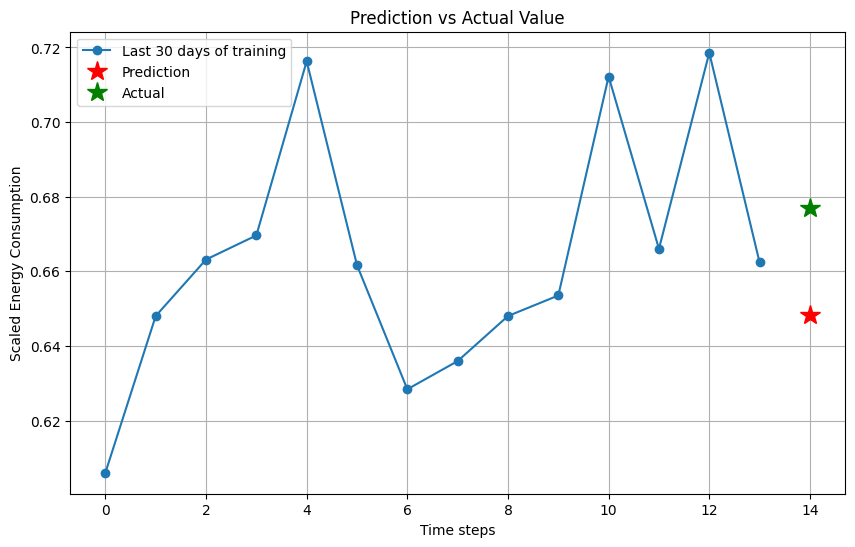

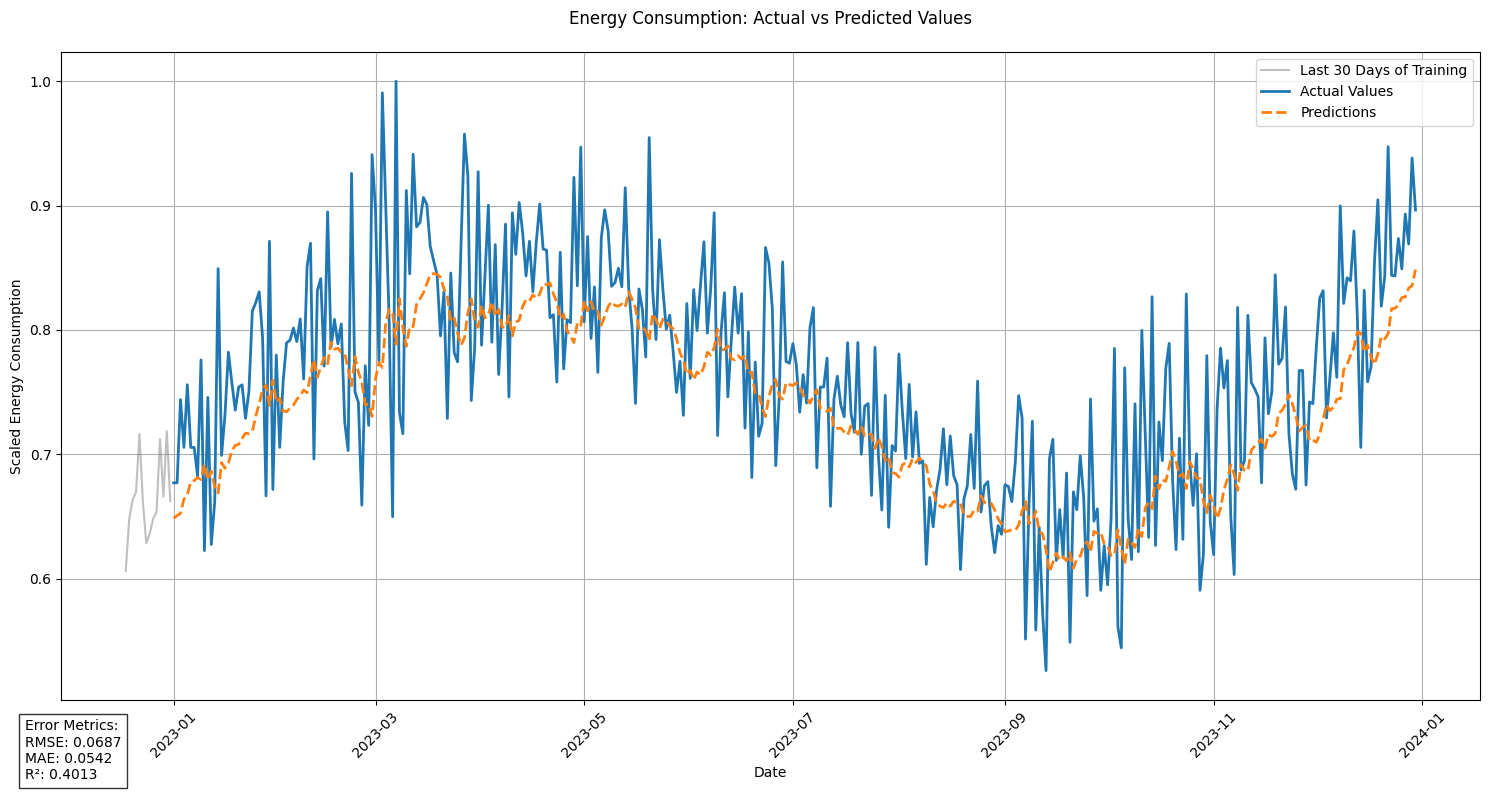


Detailed Performance Metrics:
Root Mean Squared Error (RMSE): 0.0687
Mean Absolute Error (MAE): 0.0542
R-squared (R²): 0.4013

Prediction Analysis:
Mean Actual Value: 0.7632
Mean Predicted Value: 0.7354
Std Actual Value: 0.0887
Std Predicted Value: 0.0652

Training model with neurons=100, timesteps=30, layers=1, optimizer=adam


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


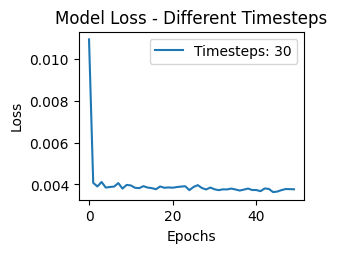

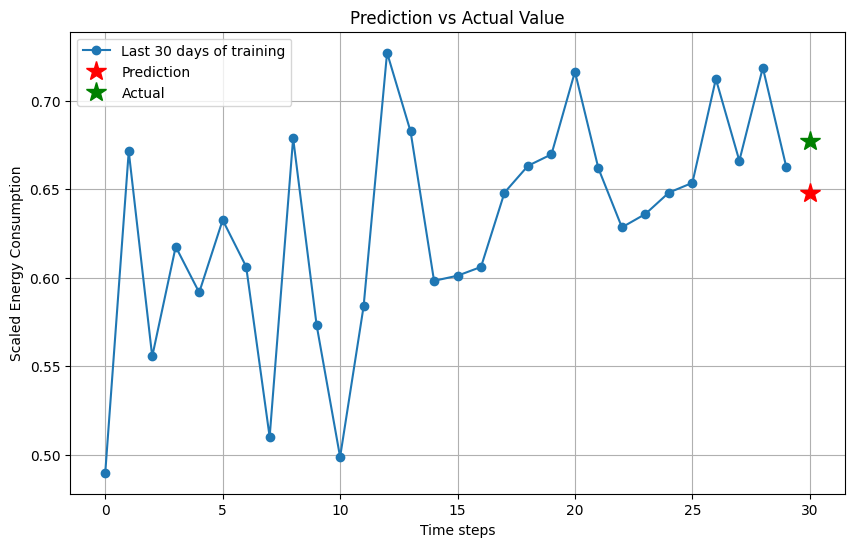

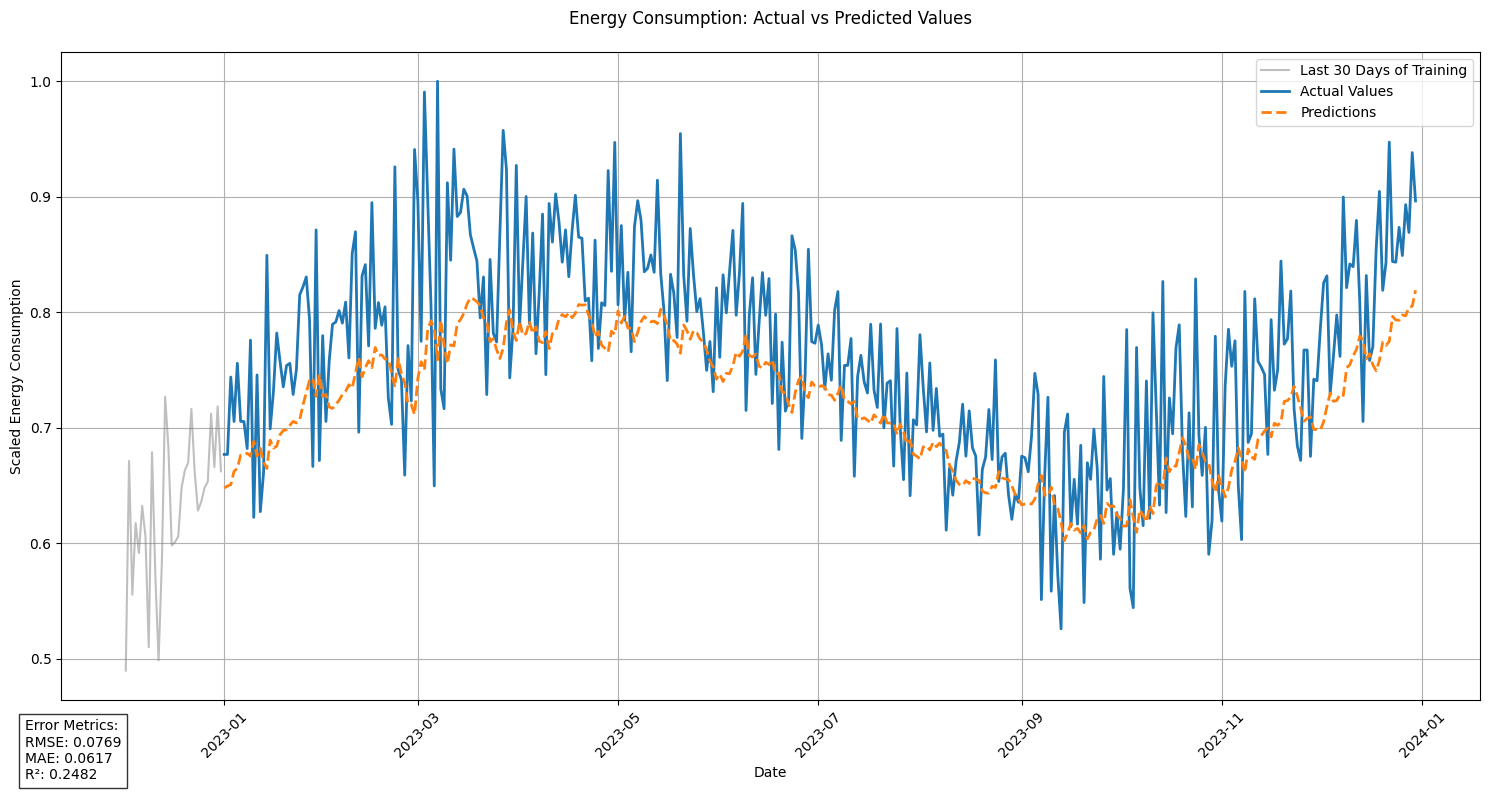


Detailed Performance Metrics:
Root Mean Squared Error (RMSE): 0.0769
Mean Absolute Error (MAE): 0.0617
R-squared (R²): 0.2482

Prediction Analysis:
Mean Actual Value: 0.7632
Mean Predicted Value: 0.7194
Std Actual Value: 0.0887
Std Predicted Value: 0.0567


In [ ]:

# Group 2: Test different timesteps (next 3 models)
print("\n=== Group 2: Testing Different Timesteps ===")
for timesteps in timesteps_options:
    key = f"timesteps_test_t{timesteps}"
    print(f"\nTraining model with neurons=100, timesteps={timesteps}, layers=1, optimizer=adam")

    model, history = create_and_fit_model(
        neurons=50,  # fixed
        timesteps=timesteps,
        layers=1,     # fixed
        optimizer='adam'  # fixed
    )

    metrics_history[key] = {
        'model': model,
        'history': history,
        'config': {'neurons': 50, 'timesteps': timesteps, 'layers': 1, 'optimizer': 'adam'}
    }

    # Plot loss for timesteps comparison
    plt.subplot(2, 2, 2)
    plt.plot(history.history['loss'], label=f'Timesteps: {timesteps}')
    plt.title('Model Loss - Different Timesteps')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Evaluate and visualize model predictions
    evaluate_and_visualize_model(model, train_data_np, test_data_np, timesteps, test_data)




=== Group 3: Testing Different Layers ===

Training model with neurons=100, timesteps=7, layers=1, optimizer=adam


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


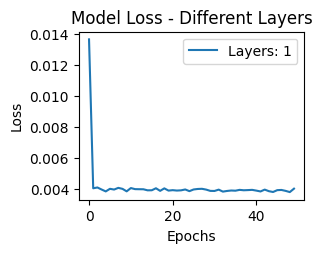

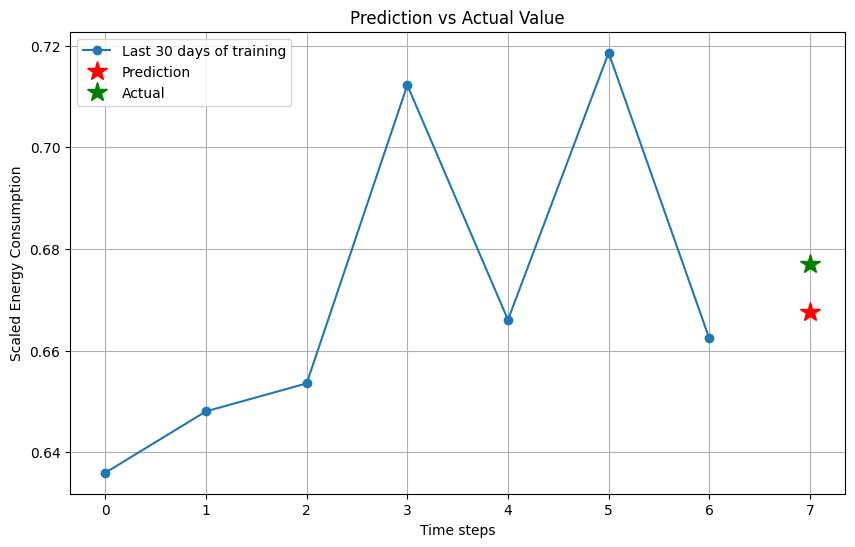

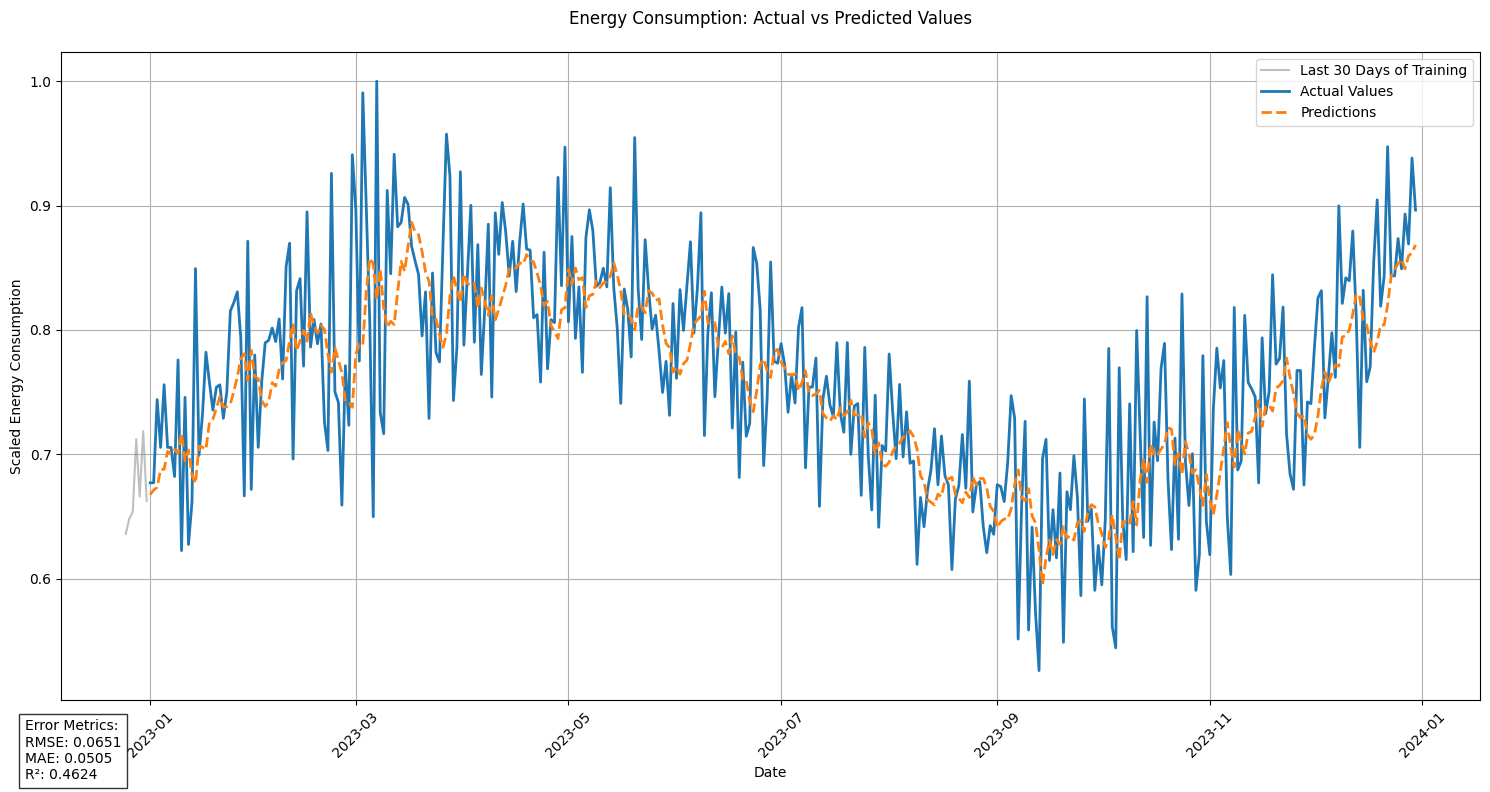


Detailed Performance Metrics:
Root Mean Squared Error (RMSE): 0.0651
Mean Absolute Error (MAE): 0.0505
R-squared (R²): 0.4624

Prediction Analysis:
Mean Actual Value: 0.7632
Mean Predicted Value: 0.7518
Std Actual Value: 0.0887
Std Predicted Value: 0.0676

Training model with neurons=100, timesteps=7, layers=2, optimizer=adam


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


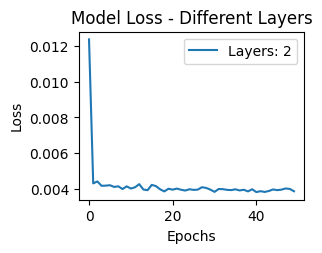

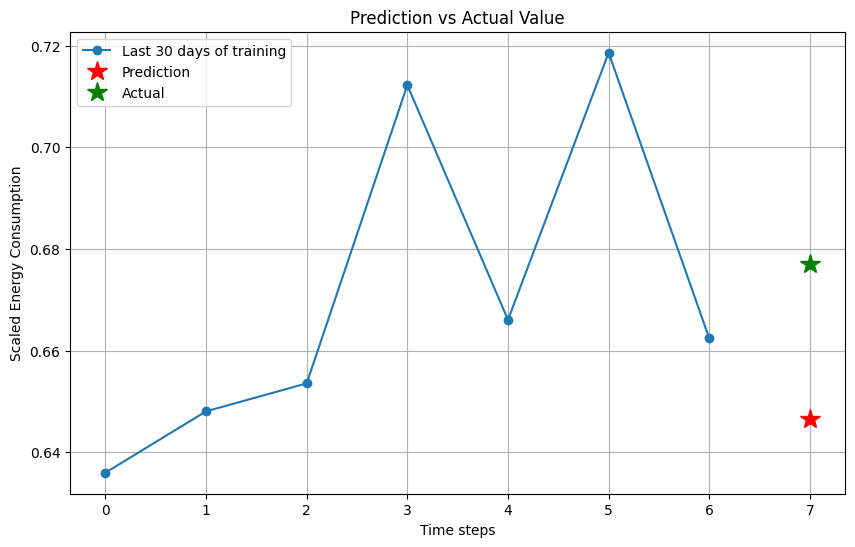

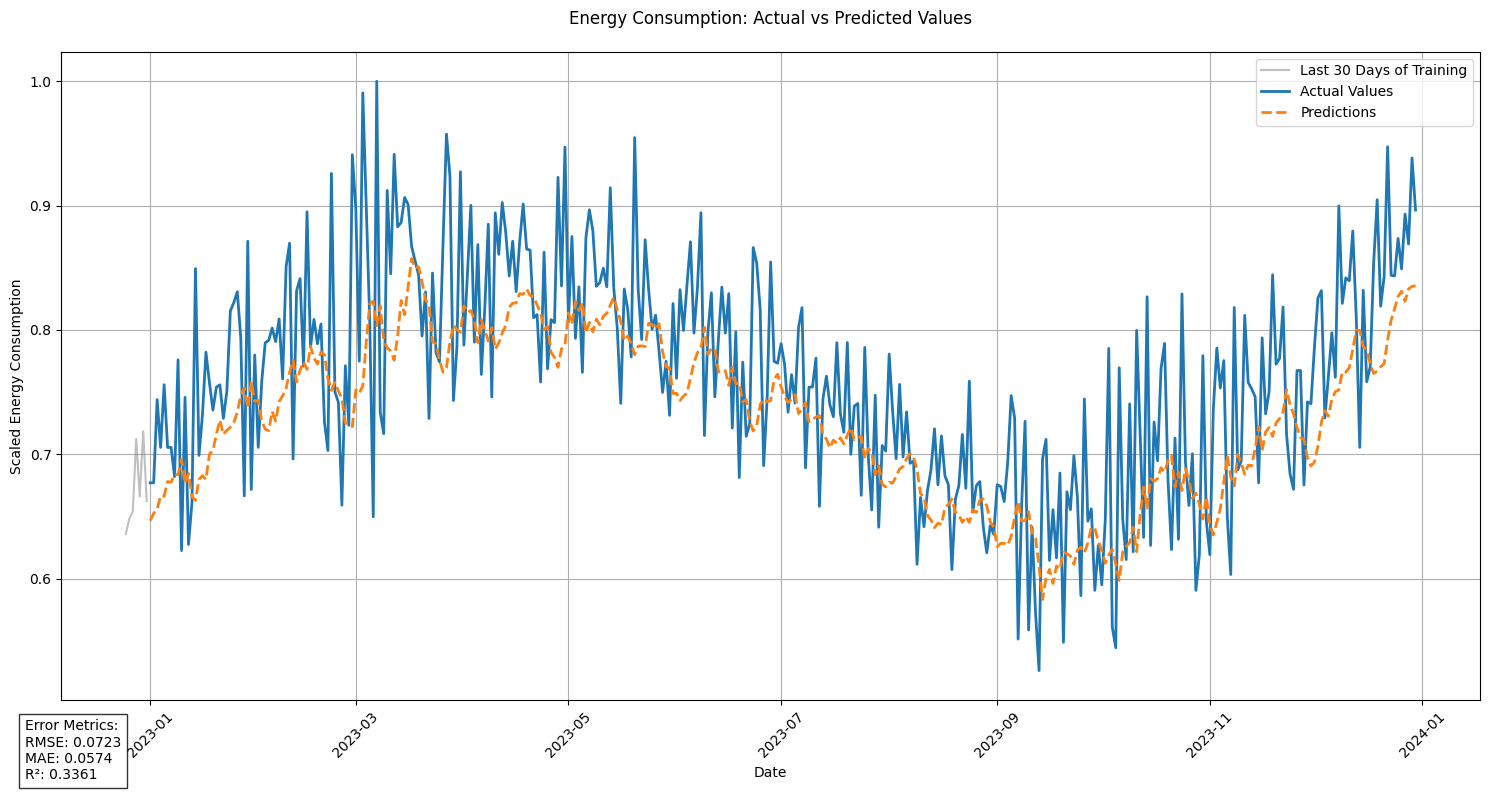


Detailed Performance Metrics:
Root Mean Squared Error (RMSE): 0.0723
Mean Absolute Error (MAE): 0.0574
R-squared (R²): 0.3361

Prediction Analysis:
Mean Actual Value: 0.7632
Mean Predicted Value: 0.7293
Std Actual Value: 0.0887
Std Predicted Value: 0.0644

Training model with neurons=100, timesteps=7, layers=3, optimizer=adam


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


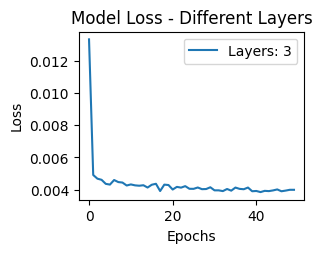

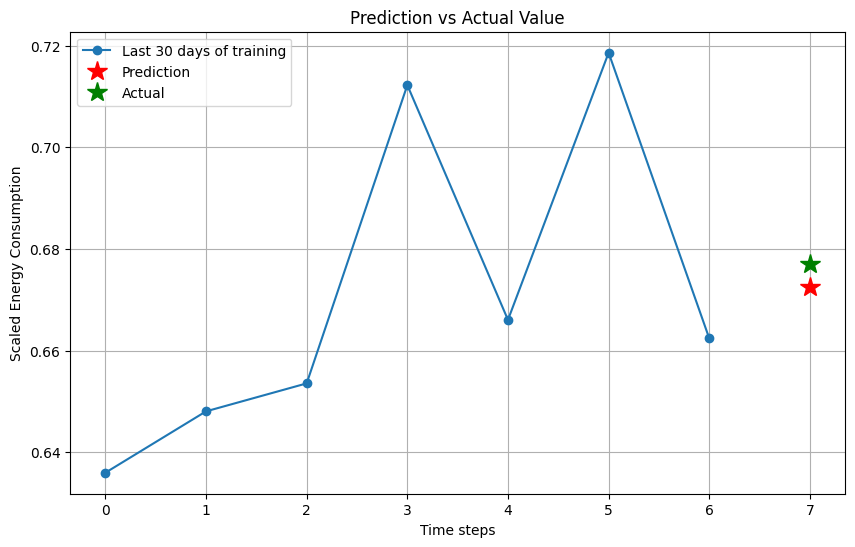

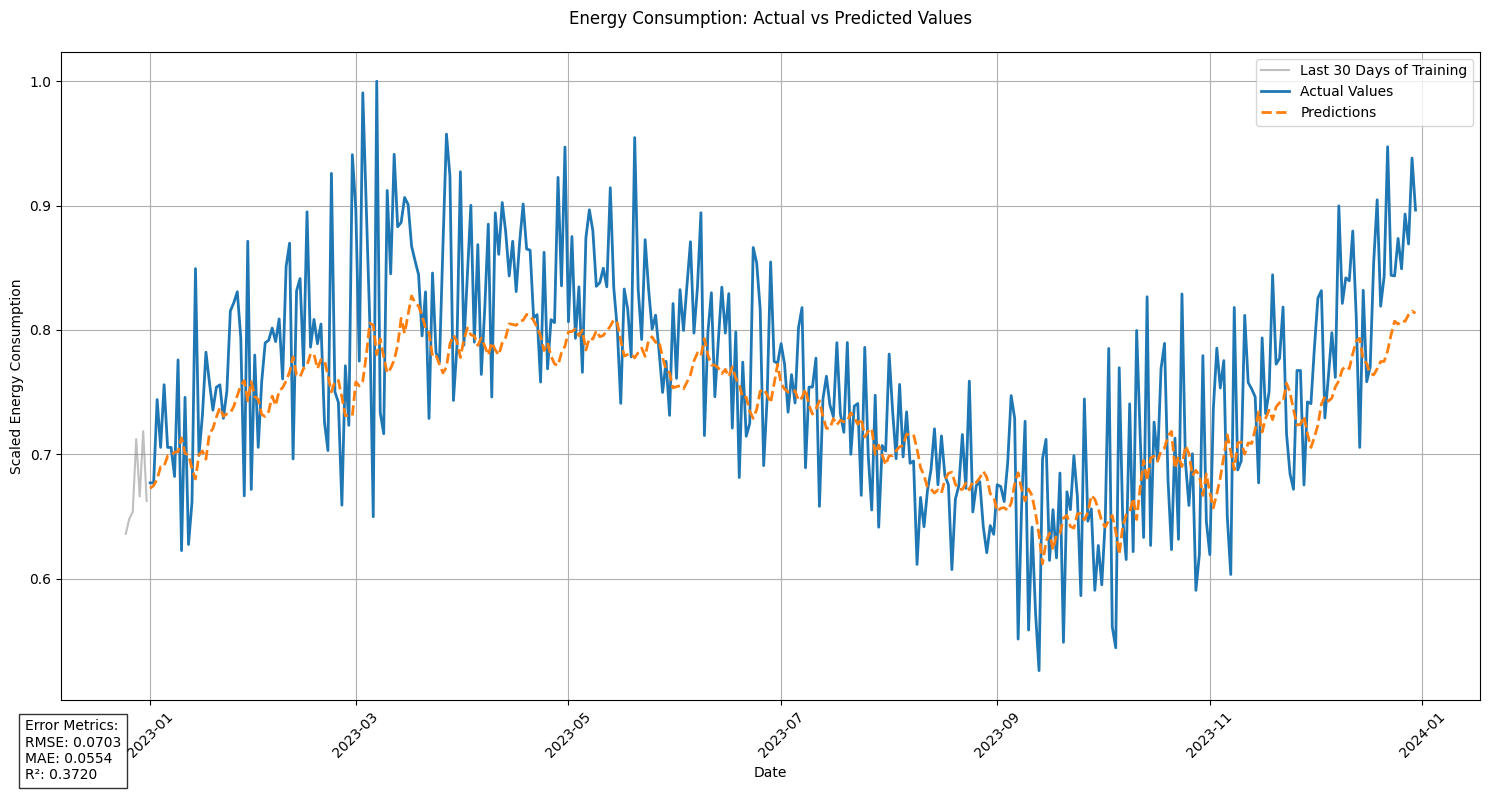


Detailed Performance Metrics:
Root Mean Squared Error (RMSE): 0.0703
Mean Absolute Error (MAE): 0.0554
R-squared (R²): 0.3720

Prediction Analysis:
Mean Actual Value: 0.7632
Mean Predicted Value: 0.7358
Std Actual Value: 0.0887
Std Predicted Value: 0.0500


In [ ]:
# Group 3: Test different layers (next 3 models)
print("\n=== Group 3: Testing Different Layers ===")
for layers in layers_options:
    key = f"layers_test_l{layers}"
    print(f"\nTraining model with neurons=100, timesteps=7, layers={layers}, optimizer=adam")

    model, history = create_and_fit_model(
        neurons=50,  # fixed
        timesteps=7,  # fixed
        layers=layers,
        optimizer='adam'  # fixed
    )

    metrics_history[key] = {
        'model': model,
        'history': history,
        'config': {'neurons': 50, 'timesteps': 7, 'layers': layers, 'optimizer': 'adam'}
    }

    # Plot loss for layers comparison
    plt.subplot(2, 2, 3)
    plt.plot(history.history['loss'], label=f'Layers: {layers}')
    plt.title('Model Loss - Different Layers')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Evaluate and visualize model predictions
    evaluate_and_visualize_model(model, train_data_np, test_data_np, 7, test_data)


In [ ]:

# Group 4: Test different optimizers (final 3 models)
print("\n=== Group 4: Testing Different Optimizers ===")
for optimizer in optimizers_options:
    key = f"optimizer_test_opt{optimizer}"
    print(f"\nTraining model with neurons=100, timesteps=7, layers=1, optimizer={optimizer}")

    model, history = create_and_fit_model(
        neurons=100,  # fixed
        timesteps=7,  # fixed
        layers=1,     # fixed
        optimizer=optimizer
    )

    metrics_history[key] = {
        'model': model,
        'history': history,
        'config': {'neurons': 100, 'timesteps': 7, 'layers': 1, 'optimizer': optimizer}
    }

    # Plot loss for optimizer comparison
    plt.subplot(2, 2, 4)
    plt.plot(history.history['loss'], label=f'Optimizer: {optimizer}')
    plt.title('Model Loss - Different Optimizers')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Evaluate and visualize model predictions
    evaluate_and_visualize_model(model, train_data_np, test_data_np, 7, test_data)


In [ ]:

# Adjust layout and display plots
plt.tight_layout()
plt.show()


<Figure size 640x480 with 0 Axes>

In [ ]:

def plot_parameter_comparisons(df: pd.DataFrame):
    """
    Create visualizations for parameter comparisons.
    """
    import matplotlib.pyplot as plt
    import seaborn as sns

    # Set up the figure
    plt.figure(figsize=(15, 10))

    # Plot 1: Neurons comparison
    plt.subplot(2, 2, 1)
    sns.boxplot(x='neurons', y='min_loss', data=df)
    plt.title('Loss Distribution by Number of Neurons')

    # Plot 2: Timesteps comparison
    plt.subplot(2, 2, 2)
    sns.boxplot(x='timesteps', y='min_loss', data=df)
    plt.title('Loss Distribution by Timesteps')

    # Plot 3: Optimizer comparison
    plt.subplot(2, 2, 3)
    sns.boxplot(x='optimizer', y='min_loss', data=df)
    plt.title('Loss Distribution by Optimizer')
    plt.xticks(rotation=45)

    # Plot 4: Layers comparison
    plt.subplot(2, 2, 4)
    sns.boxplot(x='layers', y='min_loss', data=df)
    plt.title('Loss Distribution by Number of Layers')

    plt.tight_layout()
    plt.show()